<a href="https://colab.research.google.com/github/bereml/iap/blob/master/libretas/1d_reglog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión logística

Curso: [Introducción al Aprendizaje Profundo](http://turing.iimas.unam.mx/~ricardoml/course/iap/). Profesores: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---

En este ejemplo veremos como implementar regresión logisitica para un atributo. Este modelo se puede ver como la forma más simple de una red neuronal para clasificación, por lo que es importante comprenderlo a profundidad.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/04/Pierre_Francois_Verhulst.jpg" width="150"/>
<a href="https://en.wikipedia.org/wiki/Pierre_Fran%C3%A7ois_Verhulst">Pierre François Verhulst</a> desarrollo la función logística. Imagen tomada de Wikipedia.

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
# sistema de archivos
import os
# pseudo aleatorios
import random

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch

### 1.2 Auxiliares

In [2]:
URL = 'https://raw.githubusercontent.com/bereml/iap/master/datos/iris.csv'
base_dir = '../datos'
filename = 'iris.csv'
filepath = os.path.join(base_dir, filename)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# reproducibilidad
set_seed()

## 2 Datos

Usaremos el conjunto de flores de [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set). Cuenta con cuatro atributos de entrada (ancho y alto de sépalo y pétalo) y tres clases de flores (setosa, versicolor, verginica). Este conjunto fue recolectado por [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher).

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/iris.png" width="500"/>
Fuente: Suruchi Fialoke, October 13, 2016, Classification of Iris Varieties.

### 2.1 Lectura

Descargamos los datos.

In [3]:
! mkdir {base_dir}
! wget -nc {URL} -O {filepath}

mkdir: cannot create directory '../datos': File exists
File '../datos/iris.csv' already there; not retrieving.


Utilizamos para la lectura del csv e imprimimos los primeros 5 ejemplos.

In [4]:
cols = ('largo sépalo', 'ancho sépalo', 'largo pétalo', 'ancho pétalo', 'clase')
df = pd.read_csv(filepath, names=cols)
pd.concat((df[1:2], df[50:52], df[100:102]))

,largo sépalo,ancho sépalo,largo pétalo,ancho pétalo,clase
1,4.9,3.0,1.4,0.2,Iris-setosa
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor
100,6.3,3.3,6.0,2.5,Iris-virginica
101,5.8,2.7,5.1,1.9,Iris-virginica


Obtengamos el atributo y la salida:

In [5]:
x = torch.tensor(df.iloc[:100, 3].values)
x = x.view(-1, 1).type(torch.float32)
print(x.shape)
x[:5]

torch.Size([100, 1])


tensor([[0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000]])

In [6]:
label2index = {'Iris-setosa': 0, 'Iris-versicolor': 1}
y_true = [label2index[l] for l in df.iloc[:100, 4]]
y_true = torch.tensor(y_true, dtype=torch.float32)
y_true = y_true.view(-1, 1).type(torch.int32)
print(y_true.shape)
y_true[:5]

torch.Size([100, 1])


tensor([[0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)

### 2.2 Partición entrenamiento/prueba

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/eval_trn_tst.svg" width="450"/>
&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

In [7]:
def partition(x, y, trn_pct=.8):
    """Returns a random train/test partition."""
    # generamos indices aleatorios
    rand_idx = torch.randperm(x.shape[0])
    # calculamos el tamaño de la partición de entrenamiento
    trn_size = int(x.shape[0] * trn_pct)
    # seleccionamos indices de entranamiento
    trn_idx = rand_idx[:trn_size]
    # seleccionamos indices de prueba
    tst_idx = rand_idx[trn_size:]
    # filtramos ejemplos de entrenamiento
    x_trn = x[trn_idx]
    y_trn = y[trn_idx]
    # filtramos ejemplos de prueba
    x_tst = x[tst_idx]
    y_tst = y[tst_idx]
    return x_trn, y_trn, x_tst, y_tst

In [8]:
# partición de la clase 0
x_trn0, y_true_trn0, x_tst0, y_true_tst0 = partition(x[:50], y_true[:50])
# partición de la clase 1
x_trn1, y_true_trn1, x_tst1, y_true_tst1 = partition(x[50:], y_true[50:])

Grafiquemos para tener una idea de la distribución de la particióin :

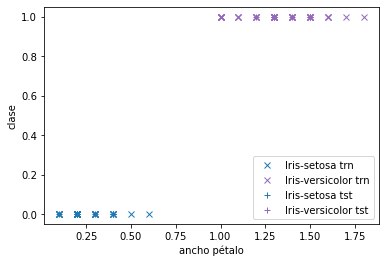

In [9]:
plt.plot(x_trn0.view(-1).numpy(), y_true_trn0.view(-1).numpy(), 
         'x', color='tab:blue', label='Iris-setosa trn')
plt.plot(x_trn1.view(-1).numpy(), y_true_trn1.view(-1).numpy(),
         'x', color='tab:purple', label='Iris-versicolor trn')
plt.plot(x_tst0.view(-1).numpy(), y_true_tst0.view(-1).numpy(), 
         '+', color='tab:blue', label='Iris-setosa tst')
plt.plot(x_tst1.view(-1).numpy(), y_true_tst1.view(-1).numpy(),
         '+', color='tab:purple', label='Iris-versicolor tst')
plt.xlabel('ancho pétalo')
plt.ylabel('clase')
plt.legend(loc='lower right')
plt.show()

Unimos las dos clases:

In [10]:
x_trn = torch.cat([x_trn0, x_trn1])
y_true_trn = torch.cat([y_true_trn0, y_true_trn1])
x_tst = torch.cat([x_tst0, x_tst1])
y_true_tst = torch.cat([y_true_tst0, y_true_tst1])

In [11]:
m, d = x_trn.shape
m, d

(80, 1)

## 3 Hipótesis

Recordemos que dado un conjunto de ejemplos con atributos ($x_1, \dots, x_d$) y salidas $y$, la hipótesis de regresión lineal considerando un plano está dada por:

$$\hat{y} = \sigma(x_1 w_1 + \dots +  x_d w_d + b)$$

donde $w_i$ y $b$ son pesos y sesgo (parámetros) del modelo, $\hat{y}$ la salida predicha, y $\sigma(\cdot)$ es la función sigmoide definida por: 


$$ \sigma(z) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-z} }  $$ 

Podemos expresar la hipótesis en su forma vectorial como:

$$\hat{y} = \sigma( x w + b)$$

Nuestro trabajo consiste en estimar (aprender) los parámetros $w_i$ y $b$. Por el momento supongamos que proponemos valores para los parámetros y hagamos inferencia:

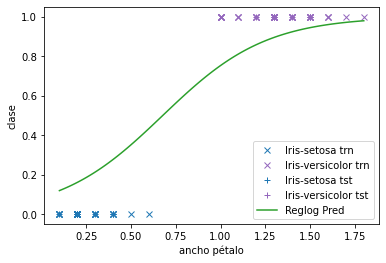

In [12]:
# parámetros que nos regalo el oráculo
w = torch.tensor([[3.4489]])
b = torch.tensor([-2.3331])

# inferencia
x = torch.linspace(x_trn.min(), x_trn.max(), 100, dtype=torch.float32).view(-1, 1)
y_pred = torch.sigmoid(x @ w + b)

# gráfica
plt.plot(x_trn0.view(-1).numpy(), y_true_trn0.view(-1).numpy(), 
         'x', color='tab:blue', label='Iris-setosa trn')
plt.plot(x_trn1.view(-1).numpy(), y_true_trn1.view(-1).numpy(),
         'x', color='tab:purple', label='Iris-versicolor trn')
plt.plot(x_tst0.view(-1).numpy(), y_true_tst0.view(-1).numpy(), 
         '+', color='tab:blue', label='Iris-setosa tst')
plt.plot(x_tst1.view(-1).numpy(), y_true_tst1.view(-1).numpy(),
         '+', color='tab:purple', label='Iris-versicolor tst')
plt.plot(x.view(-1).numpy(), y_pred.view(-1).numpy(),
         '-', color='tab:green', label='Reglog Pred')
plt.xlabel('ancho pétalo')
plt.ylabel('clase')
plt.legend(loc='lower right')
plt.show()

## 4 Función de pérdida

La pérdida para este modelo es el error cuadrático medio y queda expresado de la siguiente manera:

$$ J(w, b) = - \frac{1}{m} \sum_{i=1}^{m}{ \big( y^{(i)} log(\hat{y}^{(i)}) + (1 - y^{(i)}) log(1 - \hat{y}^{(i)}) \big) } $$

Para los parámetros propuestos, la pérdida se puede implementar como:

In [13]:
y_pred_trn = torch.sigmoid(x_trn @ w + b)
loss = - (y_true_trn * torch.log(y_pred_trn) + (1 - y_true_trn) * torch.log(1 - y_pred_trn)).mean()
loss

tensor(0.1708)

## 5 Descenso por gradiente

![graddes](https://ml-cheatsheet.readthedocs.io/en/latest/_images/gradient_descent_demystified.png)
<div style="text-align: center"> https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html </div>

El algoritmo del gradiente descendente se basa en el gradiente de la pérdida respecto de los parámetros:

$$\frac{\partial J(w_j)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m}{x^{(i)}_j(\hat{y}^{(i)} - y^{(i)})}$$

$$\frac{\partial J(b)}{\partial b} = \frac{1}{m} \sum_{i=1}^{m}{(\hat{y}^{(i)} - y^{(i)})}$$

en su forma vectorial:

$$\Delta J(w) = \frac{1}{m} x^T (\hat{y} - y)$$

$$\Delta J(b) = \frac{1}{m} \sum_{i=1}^{m}{(\hat{y} - y)^{(i)}}$$

Para los parámetros propuestos, el computo gradiente se puede implementar como:

In [14]:
grad_w = (x_trn.T @ (y_pred_trn - y_true_trn)) / m
grad_b = (y_pred_trn - y_true_trn).sum() / m
grad_w, grad_b

(tensor([[-0.0448]]), tensor(0.0345))

## 6 Entrenamiento

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/supervisado.svg" width="700"/>
&nbsp;
Ciclo de entrenamiento supervisado.

&nbsp;

Ahora implementemos todo en una función:

In [15]:
def cross_entropy(y_true, y_srcs):
    """Computes binary cross-entropy."""
    return - (y_true * torch.log(y_srcs) + (1 - y_true) * torch.log(1 - y_srcs)).mean()


def accuracy(y_true, y_pred):
    """Computes accuracy."""
    return (y_true == y_pred).type(torch.float32).mean()


def train(x_trn, y_true_trn, x_tst, y_true_tst, alpha=0.1, steps=500):
    """Fits logistic regression."""

    # ejemplos, atributos
    m, d = x.shape

    # inicialización de parámetros
    w = torch.zeros(d, 1)
    b = torch.zeros(1)

    # históricos
    loss_trn_hist, loss_tst_hist = [], []
    acc_trn_hist, acc_tst_hist = [], []

    # ciclo de entrenamiento
    for i in range(steps):
        
        # cómputo de puntajes
        y_srcs_trn = torch.sigmoid(x_trn @ w + b)
        y_srcs_tst = torch.sigmoid(x_tst @ w + b)
        
        # cómputo de clases
        y_pred_trn = y_srcs_trn.round()
        y_pred_tst = y_srcs_tst.round()

        # cómputo de la pérdida
        loss_trn = cross_entropy(y_true_trn, y_srcs_trn)
        loss_tst = cross_entropy(y_true_tst, y_srcs_tst)

        # cómputo de la exactitud
        acc_trn = accuracy(y_true_trn, y_pred_trn)
        acc_tst = accuracy(y_true_tst, y_pred_tst)

        # cómputo del gradiente
        grad_w = (x_trn.T @ (y_srcs_trn - y_true_trn)) / m
        grad_b = (y_srcs_trn - y_true_trn).sum() / m

        # actualización de parámetros
        w = w - alpha * grad_w
        b = b - alpha * grad_b

        # históricos
        loss_trn_hist.append(loss_trn)
        loss_tst_hist.append(loss_tst)
        acc_trn_hist.append(acc_trn)
        acc_tst_hist.append(acc_tst)
        
    loss_hist = loss_trn_hist, loss_tst_hist
    acc_hist = acc_trn_hist, acc_tst_hist

    return w, b, loss_hist, acc_hist

Entrenemos un modelo:

In [16]:
w, b, loss_hist, acc_hist = train(x_trn, y_true_trn, x_tst, y_true_tst)
w, b

(tensor([[3.4489]]), tensor([-2.3331]))

Grafiquemos la evolución de la pérdida:

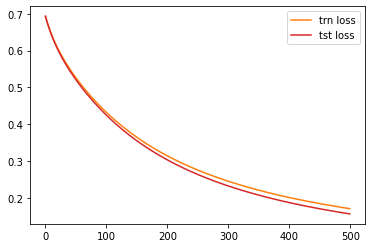

In [17]:
loss_trn_hist, loss_tst_hist = loss_hist
plt.figure()
plt.plot(range(len(loss_trn_hist)), loss_trn_hist, 
         'tab:orange', label='trn loss')
plt.plot(range(len(loss_tst_hist)), loss_tst_hist, 
         'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.show()

Grafiquemos la evolución de la exactitud:

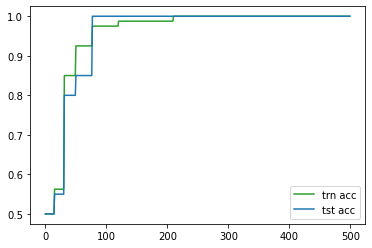

In [18]:
acc_trn_hist, acc_tst_hist = acc_hist
plt.figure()
plt.plot(range(len(acc_trn_hist)), acc_trn_hist, 
         'tab:green', label='trn acc')
plt.plot(range(len(acc_tst_hist)), acc_tst_hist, 
         'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.show()

## 7 Discusión

* ¿Qué pasa con el modelo si lo seguimos entrenando?
* ¿Conoces otras métricas para medir el desempeño de un clasificador?